In [4]:
from rasterio.features import rasterize
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

# Paths files
tif_POST = 'Data/GLCM POST.tif'
tif_PRE = 'Data/GLCM PRE.tif'

scratch_dir = './scratch' 

def print_band_info(tif_file):
    with rasterio.open(tif_file) as src:
        print(f"Information for: {tif_file}")
        print(f"Number of bands: {src.count}")
        for i in range(1, src.count + 1):
            band = src.read(i)
            print(f"Band {i} shape: {band.shape}")
        print("-" * 40)

# Print available bands
print_band_info(tif_PRE)
print_band_info(tif_POST)

Information for: Data/GLCM PRE.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------
Information for: Data/GLCM POST.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------


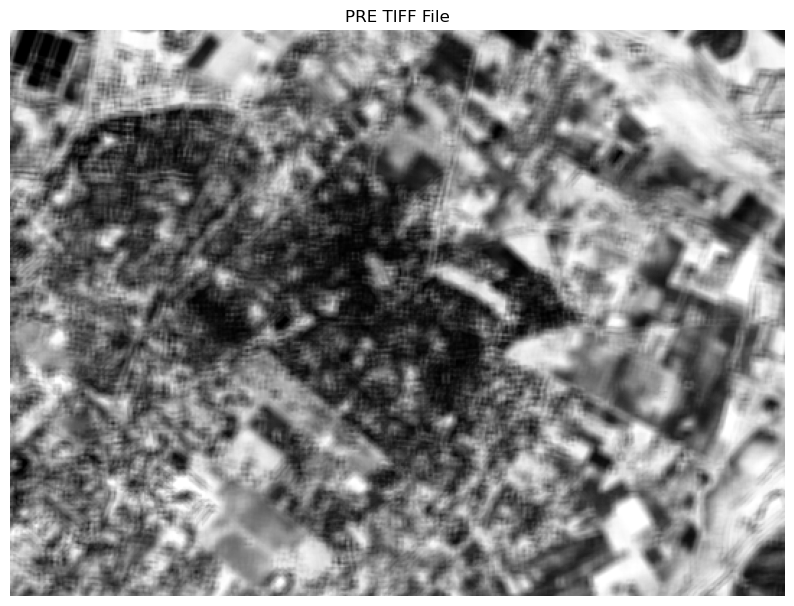

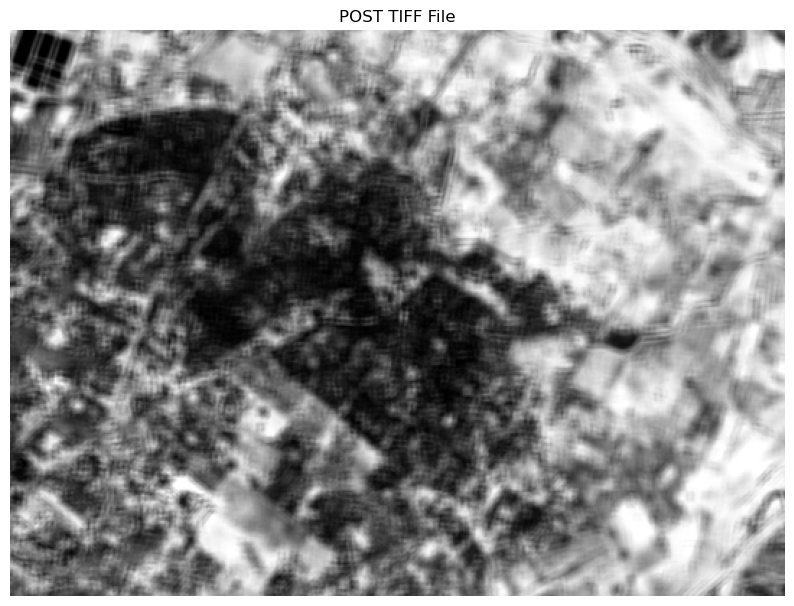

In [5]:
def display_band(tif_file, title, band_number):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least x bands
        if src.count < band_number:
            print(f"File {tif_file} does not have 8 bands.")
            return

        band = src.read(band_number)

        plt.figure(figsize=(10, 10))
        plt.imshow(band, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

display_band(tif_PRE, "PRE TIFF File", 8)
display_band(tif_POST, "POST TIFF File", 8)

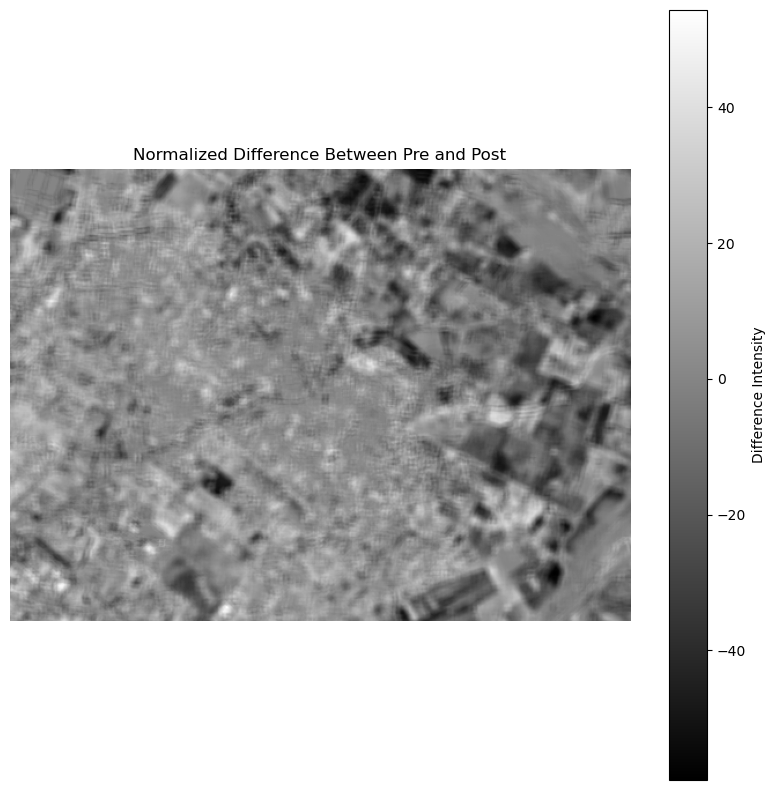

Image saved to: ./scratch/Normalized_difference.tif


In [6]:
def read_band(tif_file, band_nr):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < band_nr:
            print(f"File {tif_file} does not have 8 bands.")
            return None
        # Read the 8th band
        band = src.read(band_nr)
        return band

# Read the 8th band from both files
band_Pre = read_band(tif_PRE, 8)
band_Post = read_band(tif_POST, 8)

if band_Pre is not None and band_Post is not None:
    # Check if the bands have the same shape
    if band_Pre.shape != band_Post.shape:
        print("The bands of the two files do not have the same shape.")
    else:
        # Compute the difference
        difference = band_Pre - band_Post

        # Display the difference image
        plt.figure(figsize=(10, 10))
        plt.imshow(difference, cmap='gray')
        plt.title("Normalized Difference Between Pre and Post")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Difference Intensity')
        plt.show()

        # Use the metadata of the first file as a template for the output file
        with rasterio.open(tif_PRE) as src:
            meta = src.meta
        meta.update(count=1)

        output_tif = f"Normalized_difference.tif"
        output_tif = os.path.join(scratch_dir, output_tif)

        # Write the difference image to a new TIFF file
        with rasterio.open(output_tif, 'w', **meta) as dst:
            dst.write(difference, 1)

        print(f"Image saved to: {output_tif}")

In [7]:
# import geopandas as gpd
# 
# # Load the shapefile containing damaged areas
# damaged_areas = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')
# 
# # Print the polygons and their attribute values
# for index, row in damaged_areas.iterrows():
#     print("Polygon ID:", index)
#     print("Attributes:")
#     for column in damaged_areas.columns:
#         print(f"{column}: {row[column]}")
#     print()

Polygon ID: 0
Attributes:
osm_id: 41242992
damaged: 0
geometry: POLYGON ((34.529312 31.5372924, 34.5294063 31.537381, 34.5295156 31.5373008, 34.5294201 31.5372172, 34.529312 31.5372924))

Polygon ID: 1
Attributes:
osm_id: 41243003
damaged: 0
geometry: POLYGON ((34.5222767 31.524193, 34.5228351 31.5248926, 34.5231504 31.5246988, 34.5225723 31.5240255, 34.5222767 31.524193))

Polygon ID: 2
Attributes:
osm_id: 41243077
damaged: 1
geometry: POLYGON ((34.5234466 31.5302181, 34.5236443 31.5304289, 34.524008 31.5301781, 34.5238222 31.5299763, 34.5238084 31.5299648, 34.5234466 31.5302181))

Polygon ID: 3
Attributes:
osm_id: 41243136
damaged: 0
geometry: POLYGON ((34.5293878 31.5363871, 34.5294277 31.5365007, 34.5295834 31.5364593, 34.5296164 31.5364861, 34.5296608 31.5366055, 34.5297785 31.5365789, 34.5297691 31.5365457, 34.5298118 31.5365361, 34.5297867 31.5364612, 34.5297371 31.5364723, 34.5296957 31.5363809, 34.5296539 31.5363538, 34.5296064 31.5363558, 34.5295198 31.5363745, 34.5295074 31.

In [ ]:
import rasterio
import numpy as np
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt


def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized


with rasterio.open('Scratch/Normalized_difference.tif') as src:
    difference_image = src.read(1)
    difference_affine = src.transform

shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

rasterized_shapefile = rasterize_shapefile(shapefile, difference_affine, difference_image.shape)

X = difference_image.flatten().reshape(-1, 1)
y = rasterized_shapefile.flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

results = []
param_combinations = []


for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                rf_classifier = RandomForestClassifier(n_estimators=n_estimators, 
                                                        max_depth=max_depth,
                                                        min_samples_split=min_samples_split,
                                                        min_samples_leaf=min_samples_leaf,
                                                        random_state=42)

                rf_classifier.fit(X_train, y_train)

                y_pred = rf_classifier.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')

                results.append((accuracy, f1))
                param_combinations.append((n_estimators, max_depth, min_samples_split, min_samples_leaf))


plt.figure(figsize=(10, 6))
plt.scatter(*zip(*param_combinations), c=[f1 for accuracy, f1 in results], cmap='viridis')
plt.colorbar(label='Weighted F1 Score')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('Hyperparameter Tuning Results')
plt.grid(True)
plt.show()


best_index = np.argmax([f1 for accuracy, f1 in results])
best_params = param_combinations[best_index]
best_accuracy, best_f1 = results[best_index]

print("Best Parameters:", best_params)
print(f"Best Weighted F1 Score: {best_f1:.4f}")
